<a href="https://colab.research.google.com/github/Sautenich/Gaps-in-Deep-Learning-Knowledge/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home assignment 1 (65 pts)

## Problem 1 (25 pts)
---

Recently generative models have experience dramatic quality in terms of photorealism and quality of image generation
and it is becoming increasingly difficult to distinguish real and generated content.

In this task your goal is to develop a classifier with as high accuracy as possible that classifies whether the given image is real on synthetic.

In the following we will use the dataset from Kaggle [AI Generated Images vs Real Images](https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images/data) constructed from images scraped from the web and generated via modern generative models.

### Important notes

* You are allowed to use any pretrained model from `torchvision`, `timm` and `open_clip` . Use of any other source is <font color='red'>prohibited</font> !
* The amount of data is small. Recall the recipes and practices to combat overfitting you learned on lectures and seminars.
* In case you do not have `kaggle` account, create one and follow the instructions on [this page](https://www.kaggle.com/docs/api) to get Kaggle API token.

Prepare kaggle API token

In [2]:
!pip install kaggle # already installed on Google Colab

Put the token in `/.kaggle` directory

In [3]:
!mkdir -p ~/.kaggle


In [4]:
!pwd


/content


In [5]:
!mv /content/sample_data/kaggle (1).json ~/.kaggle

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `mv /content/sample_data/kaggle (1).json ~/.kaggle'


In [6]:
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from typing import Tuple

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

### Dataset preparation
---

Please <font color='red'>do not change</font> the lines below!

Train and test split are expected to be the same for all submissions.

In [7]:
# download and extract data
!kaggle datasets download -d cashbowman/ai-generated-images-vs-real-images
!unzip ai-generated-images-vs-real-images.zip

Dataset URL: https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images
License(s): Community Data License Agreement - Sharing - Version 1.0
ai-generated-images-vs-real-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ai-generated-images-vs-real-images.zip
replace AiArtData/AiArtData/-how-important-people-from-the-past-really-looked-11-Pics-5ffd5c0f4d77f__880.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
# split train/test data in 75/25% ration
test_ratio = 0.25
# generated images
ai_root = "AiArtData/AiArtData"
ai_paths = [os.path.join(ai_root, path) for path in os.listdir(ai_root)]
ai_labels = [0 for _ in ai_paths]
# real images
real_root = "RealArt/RealArt"
real_paths = [os.path.join(real_root, path) for path in os.listdir(real_root)]
real_labels = [1 for _ in real_paths]
# concatenate
all_img_paths = [*ai_paths, *real_paths]
all_labels = [*ai_labels, *real_labels]

train_img_paths, test_img_paths, train_labels, test_labels = train_test_split(
    all_img_paths, all_labels, test_size=0.25, random_state=42
)

In [9]:
print(ai_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
print(train_labels)

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 

Let us visualize some samples


In [11]:
import matplotlib.pyplot as plt

Real images

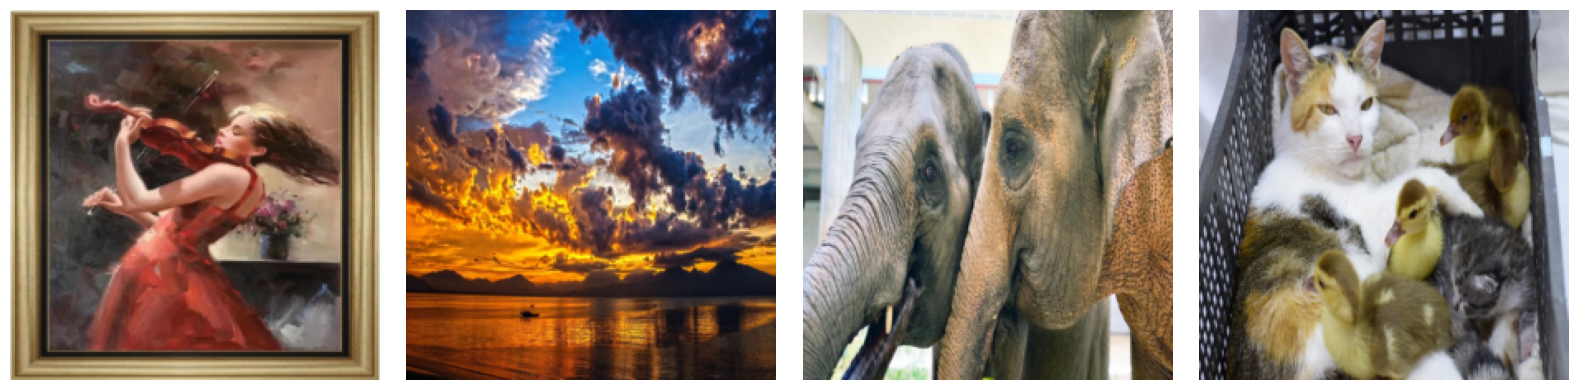

In [12]:
resize = T.Resize((224, 224))

fig, ax = plt.subplots(ncols=4, figsize=(4 * 4, 4))
for i in range(4):
    img = Image.open(real_paths[i])
    ax[i].imshow(resize(img))
    ax[i].axis('off')
fig.tight_layout()

Generated images

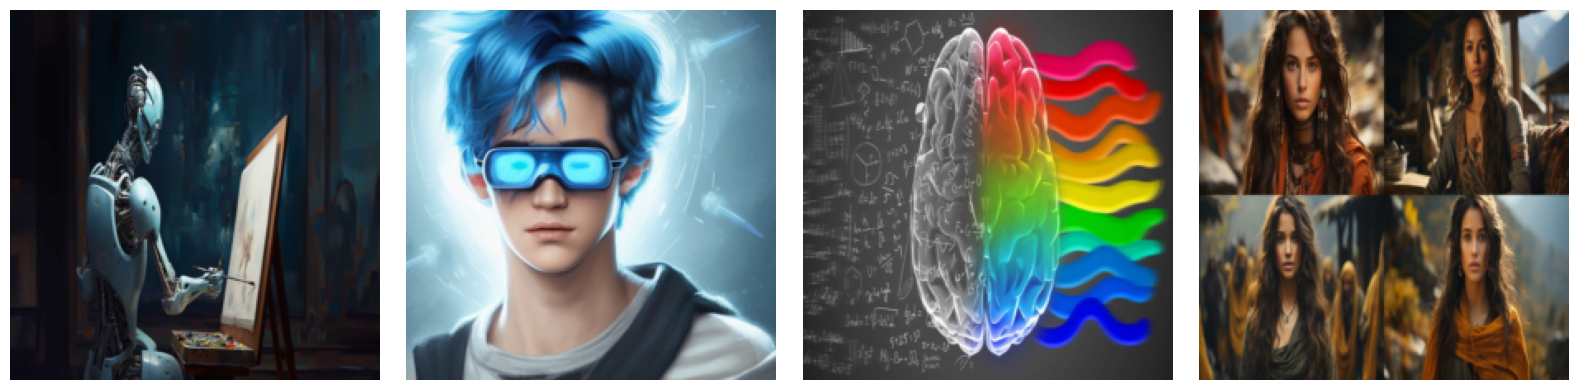

In [13]:
resize = T.Resize((224, 224))

fig, ax = plt.subplots(ncols=4, figsize=(4 * 4, 4))

for i in range(4):
    img = Image.open(ai_paths[i+5])
    ax[i].imshow(resize(img))
    ax[i].axis('off')
fig.tight_layout()

In [14]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # get image
        image = Image.open(self.img_paths[idx]).convert("RGB")
        # convert image to tensor
        if self.transform:
            image = self.transform(image)
        # get label
        label = self.labels[idx]
        return image, label

We will use ImageNet stats for normalization. (actual `mean` and `std` are quite close to the one for ImageNet)

In [15]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

1. **(1 pt )** Choose any reasonable traning transformation pipeline

In [16]:
train_transform = T.Compose([
    # TODO
    #T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    T.Resize(232, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std)
])




In [17]:
train_dataset = ImageDataset(train_img_paths, train_labels, transform=train_transform)
train_loader = DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle=True,
    num_workers=1
    #your_batch_size,
    #any additional hyperparameters
)

<font color='red'>Do not change</font> the transformations below! Evaluation setup is expected to be consistent across all submissions.

In [18]:
test_transforms = T.Compose([
    T.Resize(232, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std)]
)
test_dataset = ImageDataset(test_img_paths, test_labels, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2, pin_memory=True)

In [19]:
for i, (inputs, labels) in enumerate(train_loader):
    # Print the shape of the inputs and labels
    print(f"Batch {i+1}:")
    print(f"  Inputs shape: {inputs.shape}")
    print(f"  Labels shape: {labels.shape}")

    # Stop after the first batch for demonstration purposes
    break

Batch 1:
  Inputs shape: torch.Size([16, 3, 224, 224])
  Labels shape: torch.Size([16])


### Model
---

2. **(1 pt)** Design your own model or take any pretrained, or train from scratch model from `torchvision`, `timm` or `open_clip`.

In [20]:
import torchvision.models
# import timm (you may need !pip install timm)
# import open_clip (you may need !pip install open_clip)

In [21]:
device = "cuda"

In [22]:
# TODO your code
model = torchvision.models.mobilenet_v2(pretrained=True)



By default most models in `torchvision` or `timm` have 1000 classes. How many classes are in this case?

3. **(1 pt)** Build a classifier, suitable for a task of interest.

In [23]:
# TODO your code
# Проверим, сколько слоёв на конце сетки
#num_ftrs = model.classifier[1].in_features
#model.fc = nn.Linear(num_ftrs, 2)

model.classifier[1] = nn.Linear(1280, 2)

print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [25]:
for (inputs, targets) in train_loader:
    optimizer.zero_grad()
    outputs=model(inputs)
    probabilities = F.softmax(outputs, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1)
    print('predictions', predicted_classes)
    print('outputs_size = ', outputs.size())
    print('targets_size = ',  targets.size())
    print('outputs', outputs)
    print('targets', targets)
    break

NameError: name 'optimizer' is not defined

In [27]:
#Заметка: Loss-function для бинарной классификации принимает на себя логиты
import torch
import torch.nn as nn
import torch.optim as optim

# Example model output (logits) from the model:
# Let's say batch size is 4, and output shape is [4, 2] (for two classes)
logits = torch.randn(4, 2)  # Example model output logits
print(f"Logits = {logits}")
# Ground truth labels (0 or 1 for binary classification)
# These should match the shape of the model output after sigmoid
targets = torch.tensor([0, 1, 0, 1], dtype=torch.float32)
print(f"Target = {targets}")

# Apply sigmoid to the logits to get probabilities for class 1 (positive class)
probabilities_class_1 = torch.sigmoid(logits[:, 1])


# Define binary cross entropy loss
loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss
print('probabilities_class_1 =', probabilities_class_1)
#print('targets =', targets)

# Compute loss
loss = loss_fn(probabilities_class_1, targets)
print(f"Binary Cross Entropy Loss: {loss.item()}")

Logits = tensor([[ 0.5846, -2.3001],
        [-0.9742, -0.8675],
        [ 0.0308,  1.2421],
        [ 0.2939,  1.6852]])
Target = tensor([0., 1., 0., 1.])
probabilities_class_1 = tensor([0.0911, 0.2958, 0.7759, 0.8436])
Binary Cross Entropy Loss: 0.7448989152908325


In [55]:
logits

tensor([[ 0.5846, -2.3001],
        [-0.9742, -0.8675],
        [ 0.0308,  1.2421],
        [ 0.2939,  1.6852]])

In [56]:
logits.squeeze()

tensor([[ 0.5846, -2.3001],
        [-0.9742, -0.8675],
        [ 0.0308,  1.2421],
        [ 0.2939,  1.6852]])

Prepare training loop and necessary functions.

4. **(1 pt)** Implement metric to measure model performance
5. **(3 pts)** Implement training loop
6. **(2 pts)** Implement validation loop

In [55]:
def one_hot_encode(labels, num_classes=2):
    return torch.eye(num_classes)[labels]

# TODO
def binary_accuracy(logits: torch.Tensor, target: torch.Tensor) -> float:
    """
    Args:
        logits - model prediction logits
        target - ground truth labels
    Returns:
        classificiation accuracy
    """
    # Применяем сигмоиду к логитам, чтобы получить вероятности для класса 1
    probabilities_ba = torch.sigmoid(logits)

    # Преобразуем вероятности в предсказания (0 или 1)
    predictions = (probabilities_ba[:,1] >= 0.5).float()

    # Сравниваем предсказания с истинными метками
    correct = (predictions == target).float()

    # Вычисляем точность как долю правильных предсказаний
    accuracy = correct.sum() / target.size(0)

    return accuracy.item()
    #pass

# TODO
def train_epoch(model, train_loader, optimizer, loss_fn, device, scheduler=None) -> Tuple[float, float]:
    """
    Training loop
    Args:
        model: model
        val_loader: validation loader
        optimizer: optimizer
        loss_fn: loss function
        device: device computations are run
        scheduler: (optional) - if using learning rate scheduler
    """

    # What should you do with model on training?

    model.train()
    avg_loss = 0
    avg_acc1 = 0
    running_loss = 0.0
    running_accuracy = 0.0

    for (inputs, targets) in tqdm(train_loader):
        optimizer.zero_grad()
        logits=model(inputs)
        # Применение сигмоиды для преобразования логитов в вероятности
        targets_one_hot = one_hot_encode(targets, num_classes=2) #.to(device)


        # Выбираем вероятности для второго класса (класс 1)

        loss = loss_fn(logits, targets_one_hot)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += binary_accuracy(logits, targets)
        scheduler.step()

    #print(len(train_loader))
    avg_loss = running_loss/len(train_loader)
    avg_acc1 = running_accuracy/len(train_loader)

    return avg_loss, avg_acc1

# TODO
def val_epoch(model, val_loader, loss_fn, device) -> Tuple[float, float]:
    """
    Validation loop

    Args:
        model: model
        val_loader: validation loader
        loss_fn: loss function
        device: device computations are run

    Returns:
        Validation loss and accuracy
    """
    # What should you with model on validation?
    avg_loss = 0.0
    correct = 0
    total = 0
    running_loss = 0.0
    running_accuracy=0.0
    model.eval()

    with torch.no_grad():
      for (inputs, targets) in val_loader:
          logits=model(inputs)
          # probabilities = torch.sigmoid(logits)  # Преобразует логиты в вероятности (batch_size, 2)
          # probabilities_class_1 = probabilities[:, 1]
          #loss = loss_fn(logits, targets.float())




          targets_one_hot = one_hot_encode(targets, num_classes=2) #.to(device)

          loss = loss_fn(logits, targets_one_hot)
          running_loss += loss.item()
          running_accuracy += binary_accuracy(logits, targets)
          # print(f'Running_loss = {running_loss}')
          # print(f'Running_accuracy = {running_accuracy}')

    print(f"len(val_loader)={len(val_loader)}")
    avg_loss = running_loss/len(val_loader)
    avg_acc1 = running_accuracy/len(val_loader)

    return avg_loss, avg_acc1

Now the goal is achieve as high accuracy as possible.

Set up any number of epochs, learning rate, regularization and other hyperparameters that yield best performance on hold-out data.

**Note**. If you decide to use early stopping, **do not use** ⛔ test data, that in practical cases is not available. You can create `devset` from subset of traning data.

In [57]:
num_epochs = 25# TODO

6. **(1 pt)** Prepare optimizer and scheduler.
7. **(1 pt)** Choose suitable loss function.

In [53]:
# TODO
import torch.optim as optim

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # TODO

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Используйте Adam
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

#loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()


# TODO what it the suitable loss function for the current task?

8. **(max 15 pts)** Final performance.

The grading criteria are the following:
* Test accuracy $\in (0.00, 0.75)$ - **0 pts**
* Test accuracy $\in [0.75, 0.80)$ - **5 pts**
* Test accuracy $\in [0.80, 0.85)$ - **10 pts**
* Test accuracy $\in [0.85, 1.00)$ - **15 pts**

You are expected to provide **all the steps** that lead you to solution, i.e which ideas worked and which did not.

Submissions without decription of the experimental setup and the path that lead to the final result will receive **0 pts** for this section.

In [59]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
  print(f"Epoch {epoch}")
  train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device='cuda', scheduler=scheduler)
  print(f"Train loss {train_loss:.3f}. Train acc {train_acc:.3f}")
  test_loss, test_acc = val_epoch(model, test_loader, loss_fn, device='cuda')
  print(f"Test loss {test_loss:.3f}. Test acc {test_acc:.3f}")
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)


Epoch 0


100%|██████████| 46/46 [02:05<00:00,  2.72s/it]


Train loss 0.207. Train acc 0.946
len(val_loader)=1
Test loss 0.596. Test acc 0.791
Epoch 1


100%|██████████| 46/46 [02:04<00:00,  2.70s/it]

Train loss 0.186. Train acc 0.954


len(val_loader)=1
Test loss 0.586. Test acc 0.787
Epoch 2


100%|██████████| 46/46 [02:05<00:00,  2.73s/it]

Train loss 0.189. Train acc 0.957


len(val_loader)=1
Test loss 0.595. Test acc 0.803
Epoch 3


100%|██████████| 46/46 [02:03<00:00,  2.68s/it]

Train loss 0.175. Train acc 0.963


len(val_loader)=1
Test loss 0.591. Test acc 0.787
Epoch 4


100%|██████████| 46/46 [02:04<00:00,  2.71s/it]

Train loss 0.183. Train acc 0.969


len(val_loader)=1
Test loss 0.590. Test acc 0.803
Epoch 5


100%|██████████| 46/46 [02:04<00:00,  2.71s/it]

Train loss 0.178. Train acc 0.969


len(val_loader)=1
Test loss 0.589. Test acc 0.803
Epoch 6


100%|██████████| 46/46 [02:04<00:00,  2.70s/it]

Train loss 0.184. Train acc 0.966


len(val_loader)=1
Test loss 0.617. Test acc 0.795
Epoch 7


100%|██████████| 46/46 [02:04<00:00,  2.70s/it]

Train loss 0.164. Train acc 0.974


len(val_loader)=1
Test loss 0.591. Test acc 0.791
Epoch 8


100%|██████████| 46/46 [02:04<00:00,  2.71s/it]

Train loss 0.158. Train acc 0.976


len(val_loader)=1
Test loss 0.577. Test acc 0.799
Epoch 9


100%|██████████| 46/46 [02:04<00:00,  2.70s/it]

Train loss 0.204. Train acc 0.943


len(val_loader)=1
Test loss 0.586. Test acc 0.791
Epoch 10


100%|██████████| 46/46 [02:04<00:00,  2.70s/it]

Train loss 0.178. Train acc 0.965


len(val_loader)=1
Test loss 0.593. Test acc 0.795
Epoch 11


100%|██████████| 46/46 [02:03<00:00,  2.68s/it]

Train loss 0.171. Train acc 0.977


len(val_loader)=1
Test loss 0.581. Test acc 0.791
Epoch 12


100%|██████████| 46/46 [02:04<00:00,  2.70s/it]

Train loss 0.171. Train acc 0.976


len(val_loader)=1
Test loss 0.595. Test acc 0.787
Epoch 13


100%|██████████| 46/46 [02:02<00:00,  2.67s/it]

Train loss 0.168. Train acc 0.971


len(val_loader)=1
Test loss 0.607. Test acc 0.811
Epoch 14


100%|██████████| 46/46 [02:08<00:00,  2.79s/it]

Train loss 0.179. Train acc 0.971


len(val_loader)=1
Test loss 0.600. Test acc 0.803
Epoch 15


100%|██████████| 46/46 [02:03<00:00,  2.69s/it]

Train loss 0.188. Train acc 0.957


len(val_loader)=1
Test loss 0.586. Test acc 0.795
Epoch 16


100%|██████████| 46/46 [01:56<00:00,  2.52s/it]

Train loss 0.185. Train acc 0.959


len(val_loader)=1
Test loss 0.573. Test acc 0.803
Epoch 17


100%|██████████| 46/46 [01:54<00:00,  2.49s/it]

Train loss 0.173. Train acc 0.962


len(val_loader)=1
Test loss 0.570. Test acc 0.799
Epoch 18


100%|██████████| 46/46 [01:54<00:00,  2.48s/it]

Train loss 0.180. Train acc 0.959


len(val_loader)=1
Test loss 0.580. Test acc 0.795
Epoch 19


100%|██████████| 46/46 [01:52<00:00,  2.45s/it]

Train loss 0.173. Train acc 0.966


len(val_loader)=1
Test loss 0.573. Test acc 0.799
Epoch 20


100%|██████████| 46/46 [01:53<00:00,  2.47s/it]

Train loss 0.186. Train acc 0.967


len(val_loader)=1
Test loss 0.586. Test acc 0.807
Epoch 21


100%|██████████| 46/46 [01:55<00:00,  2.50s/it]

Train loss 0.176. Train acc 0.964


len(val_loader)=1
Test loss 0.602. Test acc 0.799
Epoch 22


100%|██████████| 46/46 [01:53<00:00,  2.47s/it]

Train loss 0.174. Train acc 0.969


len(val_loader)=1
Test loss 0.604. Test acc 0.795
Epoch 23


100%|██████████| 46/46 [01:57<00:00,  2.55s/it]

Train loss 0.158. Train acc 0.981


len(val_loader)=1
Test loss 0.577. Test acc 0.795
Epoch 24


100%|██████████| 46/46 [01:55<00:00,  2.51s/it]

Train loss 0.217. Train acc 0.961


len(val_loader)=1
Test loss 0.591. Test acc 0.803


In [ ]:
  test_loss, test_acc = val_epoch(model, test_loader, loss_fn, device='cuda')
  print(f"Test loss {test_loss:.3f}. Test acc {test_acc:.3f}")

In [43]:
model.eval()  # Set the model to evaluation mode

# You want to use data from the DataLoader
# Assuming you want to use the first batch in train_loader
with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate through the DataLoader to get the first batch
    for inputs, targets in train_loader:
        # Make predictions for the current batch
        predictions = model(inputs)

        # Post-process the predictions: Convert probabilities to class labels (0 or 1)
        predicted_labels = (predictions > 0.5).float()

        # Print the results
        print("Predictions (probabilities):", predictions)
        print("Predicted Labels (0 or 1):", predicted_labels)
        break  # Exit after the first batch, if you only want to process one batch

Predictions (probabilities): tensor([[ 1.3733e-02, -3.9438e-01],
        [ 3.8262e-03,  9.2120e-01],
        [-5.3675e-03, -1.0322e+00],
        [-8.1969e-02,  5.2231e+00],
        [ 6.2716e-02, -1.0684e+00],
        [ 2.6271e+00, -7.7686e+00],
        [ 1.1642e-01, -1.9299e+00],
        [-7.7471e-03,  3.4754e+00],
        [-4.7546e-02,  2.4507e+00],
        [-1.1987e-01,  4.2547e+00],
        [-1.1447e-01,  3.7910e+00],
        [-7.1256e-02,  4.5311e+00],
        [ 2.4648e-02, -5.2117e-01],
        [-2.6100e-02,  4.6778e-01],
        [-1.7945e-02,  9.8627e-02],
        [-3.6728e-02, -1.1485e+00]])
Predicted Labels (0 or 1): tensor([[0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


In [39]:
train_dataset[0]

(tensor([[[-1.3302, -1.4843, -1.4158,  ..., -1.4843, -1.5014, -1.4500],
          [-1.3644, -1.4672, -1.4329,  ..., -1.2445, -1.2445, -1.0733],
          [-1.3815, -1.4843, -1.4329,  ..., -1.1760, -1.2959, -1.2445],
          ...,
          [-1.5699, -1.5528, -1.5528,  ..., -2.1179, -2.0494, -1.9809],
          [-1.5870, -1.5699, -1.5528,  ..., -2.1008, -2.0494, -1.9809],
          [-1.5870, -1.5870, -1.5699,  ..., -2.0837, -2.0323, -2.0152]],
 
         [[-1.4755, -1.6155, -1.5455,  ..., -1.8431, -1.8782, -1.8431],
          [-1.4580, -1.5980, -1.5280,  ..., -1.6856, -1.6856, -1.5280],
          [-1.4580, -1.5980, -1.5280,  ..., -1.5805, -1.6681, -1.5805],
          ...,
          [-1.9132, -1.8957, -1.8957,  ..., -1.9482, -1.8782, -1.7556],
          [-1.9307, -1.9132, -1.8957,  ..., -1.9307, -1.8431, -1.7206],
          [-1.9307, -1.9307, -1.9307,  ..., -1.8957, -1.7731, -1.6856]],
 
         [[-1.3164, -1.4384, -1.4036,  ..., -1.8044, -1.8044, -1.8044],
          [-1.3339, -1.4733,

Your awesome report
---

TODO

## Problem 2. Segmentation. (40 pts)

In this task, your challenge is to perform semantic segmentation on images from the [PASCAL Visual Object Classes (VOC)](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html) dataset. The PASCAL VOC dataset is a well-known dataset in computer vision that includes images of 20 object categories with annotations for classification, detection, and segmentation tasks. Your objective is to develop a segmentation model capable of accurately identifying and delineating multiple object categories within an image, such as animals, vehicles, and household objects. Download the training/validation data (2GB tar file). All the images are shared in the folder "JPEGImages", and the annotated images are available under the "SegmentationClass" folder. Use the [train.txt](https://drive.google.com/file/d/1upvDgz5cU6A3S7GR17huuqVbmAcj0Aeu/view?usp=sharing) and [test.txt](https://drive.google.com/file/d/19KBwTTN8h9z_LJnfD74mp6_OmPFRSZ4j/view?usp=sharing) files for training and testing your model.

Please follow these guidelines and requirements:

- You may consider resizing images to a manageable resolution (e.g., 512x512 pixels) to streamline the experimentation process. Utilize a standard train-test split as recommended for the PASCAL VOC dataset.
- **(20 pts)** Implement the necessary components of the train-test pipeline, including dataset preparation, model (You can use predefined architectures like Unet), model training, and testing. Assess your model's performance on the test dataset.
  - **(10 pts) Bonus:** your own model, not taken from libraries and not a Unet.
- **(5 pts)** Compute and report the Intersection over Union (IoU) and Dice scores for each category on the test set.
- **(5 pts)** Incorporate image augmentations to enhance model accuracy. You may find augmentation libraries such as Albumentations or Kornia beneficial for this purpose.
- **(2 pts)** Exhibit 4-6 examples of your segmentation results on the test dataset, showcasing the best and worst results based on loss/metrics.
- **(3 pts)** Thoroughly explain your methodological approach to this task. Describe the experiments you conducted, their outcomes, and the reasoning behind your decisions. Evaluate the appropriateness of the metrics you used.
- **(5 pts)** Create a function for model inference that accepts an image path. Verify your model's effectiveness on several external images not from the dataset, to gauge its generalizability.
- Refrain from using models that are pre-trained on the PASCAL VOC dataset to maintain the integrity of the competition.
- **Bonus Points:**
  - **+10 points** for attaining the top-1 result.
  - **+8 points** for achieving 2nd or 3rd place.
  - **+5 points** for ranking 4th to 8th, based on the reported mean Dice score on your chosen test split.
